# Introduction to vector databases on S&P 500 news

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [2]:
df_news = pd.read_csv('./data/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [3]:
# CODE HERE
# Use as many coding cells as you need
# Step 1: Combine TITLE and SUMMARY into a new column 'EMBEDDED_TEXT'
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + '. ' + df_news['SUMMARY']

In [4]:
# Step 2: Load the pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Step 3: Define Custom Vector Store Class
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        """
        Initialize the vector store by embedding the documents and storing their metadata.

        Args:
            embedding_model: SentenceTransformer model to encode the text.
            documents (list of str): List of text documents to embed.
            metadata (list of dict): List of metadata corresponding to each document.
        """
        assert len(documents) == len(metadata), "Documents and metadata must have the same length."
        
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.embedding_model.encode(documents, show_progress_bar=True)
    
    def search(self, query, k=5, metadata_filter=None):
        """
        Perform semantic search on the documents using a query.

        Args:
            query (str): The search query.
            k (int): Number of top results to return.
            metadata_filter (callable, optional): A function that accepts a metadata dict and returns True/False.

        Returns:
            List of tuples: (document, metadata, similarity score)
        """
        # Apply metadata filter if provided
        if metadata_filter is not None:
            filtered = [(doc, meta, emb) for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings) if metadata_filter(meta)]
            if not filtered:
                return []
            docs, metas, embs = zip(*filtered)
        else:
            docs, metas, embs = self.documents, self.metadata, self.embeddings

        # Compute embedding for the query
        query_emb = self.embedding_model.encode([query])
        
        # Compute cosine similarity
        similarities = cosine_similarity(query_emb, embs)[0]

        # Get top k indices
        top_indices = np.argsort(similarities)[::-1][:k]
        
        # Return top k results
        results = [(docs[i], metas[i], similarities[i]) for i in top_indices]
        return results


## Create and populate the vector store
 
 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.
 
 After initializing the store, you should be able to perform searches using: 
'store.search("Apple earnings", k=3)'


In [6]:
# CODE HERE
# Use as many coding cells as you need
# Convert the EMBEDDED_TEXT column to a list of strings
document_texts = df_news['EMBEDDED_TEXT'].tolist()
# Create a list of metadata dictionaries for each row
metadata_list = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')


In [7]:
# Instantiate the custom vector store with the embedding model, documents, and metadata
store = CustomVectorStore(embedding_model=model, documents=document_texts, metadata=metadata_list)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

## Using your vector store and analyzing the results

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [8]:
# CODE HERE
# Use as many coding cells as you 
# Perform semantic search for the query "AI announcement"
query = "AI announcement"
results = store.search(query, k=50)

In [9]:
# Display the top 50 results
for i, (doc, meta, score) in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"TICKER: {meta['TICKER']}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"Similarity Score: {score:.4f}")
    print(f"Document Text:\n{doc}")
    print("-" * 100)


Result 1:
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
Similarity Score: 0.5574
Document Text:
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
----------------------------------------------------------------------------------------------------

Result 2:
TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
Similarity Score: 0.5518
Document Text:
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
-----------------------------------------

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?
 
 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [10]:
# CODE HERE
# Use as many coding cells as you need
from collections import Counter

# Extract TICKERs from metadata
tickers = [meta['TICKER'] for _, meta, _ in results]

# Count frequency of each TICKER
ticker_counts = Counter(tickers)

# Print top TICKERs
print("Top companies (by TICKER) in the top 50 AI announcement results:\n")
for ticker, count in ticker_counts.most_common():
    print(f"{ticker}: {count} appearances")


Top companies (by TICKER) in the top 50 AI announcement results:

PLTR: 5 appearances
BKR: 3 appearances
AMD: 3 appearances
QCOM: 2 appearances
GOOG: 2 appearances
AMZN: 2 appearances
EXPE: 2 appearances
MSFT: 2 appearances
CTSH: 2 appearances
INTC: 2 appearances
JKHY: 1 appearances
ADBE: 1 appearances
WSM: 1 appearances
CEG: 1 appearances
RSG: 1 appearances
NVDA: 1 appearances
INTU: 1 appearances
GOOGL: 1 appearances
NFLX: 1 appearances
YUM: 1 appearances
SMCI: 1 appearances
ORCL: 1 appearances
META: 1 appearances
ABNB: 1 appearances
PYPL: 1 appearances
CSCO: 1 appearances
NOW: 1 appearances
ROK: 1 appearances
HPQ: 1 appearances
DELL: 1 appearances
CRM: 1 appearances
IT: 1 appearances
FFIV: 1 appearances
AVGO: 1 appearances
KMX: 1 appearances


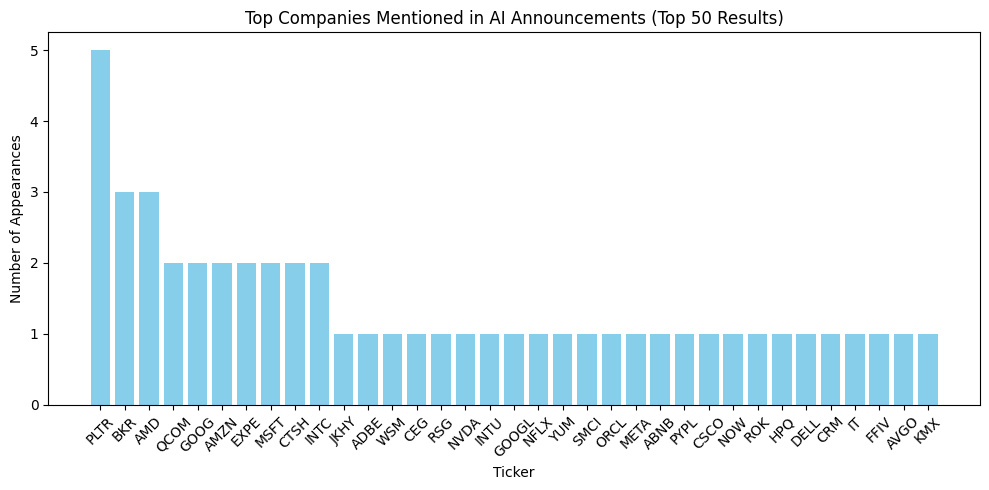

In [11]:
#Plot the Frequency 
tickers_sorted = [t for t, _ in ticker_counts.most_common()]
counts_sorted = [c for _, c in ticker_counts.most_common()]

plt.figure(figsize=(10, 5))
plt.bar(tickers_sorted, counts_sorted, color='skyblue')
plt.xlabel("Ticker")
plt.ylabel("Number of Appearances")
plt.title("Top Companies Mentioned in AI Announcements (Top 50 Results)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The top companies appearing most frequently in the top 50 search results for "AI announcement" are Palantir (PLTR) with 5 mentions, Baker Hughes (BKR) and AMD with 3 mentions each, followed by Qualcomm (QCOM), Google (GOOG), Amazon (AMZN), Expedia (EXPE), Microsoft (MSFT), Cognizant (CTSH), and Intel (INTC) with 2 mentions each.

I expected companies like Palantir, AMD, Google, Amazon, Microsoft, and Intel to appear frequently because they are well-known leaders or heavy investors in AI technology, whether through AI software, hardware, or cloud services.

What surprised me the most was Baker Hughes (BKR) and Expedia (EXPE). Baker Hughes is primarily an energy and industrial company, so seeing it with 3 mentions was unexpected. However, after some research, I found they have a joint venture focused on AI solutions, which explains its presence. Expedia’s appearance is also interesting since it’s a travel company, but it has been integrating AI to enhance customer experience and trip planning.

Overall, the frequency of these companies shows not only the dominance of traditional tech giants in AI announcements but also how AI is spreading to diverse industries such as energy and travel, which is quite exciting.
 

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?
 
 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

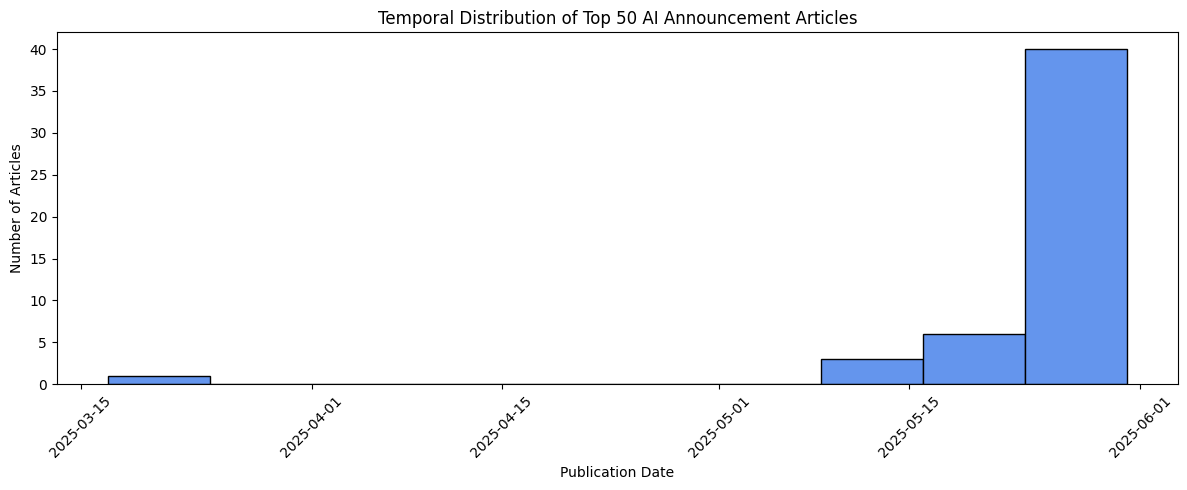

In [12]:
# CODE HERE
# Use as many coding cells as you need
# Extract publication dates from the metadata of top 50 results
dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]

# Convert to pandas datetime series for easier plotting
dates_series = pd.to_datetime(dates)

# Plot histogram to show the distribution of articles over time
plt.figure(figsize=(12, 5))
plt.hist(dates_series, bins=10, color='cornflowerblue', edgecolor='black')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.title('Temporal Distribution of Top 50 AI Announcement Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**1. Date range of the top 50 results**
The date range spans from around mid-March 2025 (approximately March 15) to late May 2025 (close to June 1). **Show that it was increasing in May.**

**2. Evenness of distribution**
No, the articles are not evenly distributed over time. The vast majority (over 80%) are clustered within a very short period in late May 2025, with only a few articles appearing in March and early May.

**3. Possible explanations for the spike in AI announcements**

* **Alignment with major industry conferences** in May (such as Google I/O, Microsoft Build, and NVIDIA GTC), where companies often reveal their latest AI products and research.
* **Coordinated marketing campaigns** where multiple tech firms time their AI announcements to maximize media coverage and compete for attention.
* **End-of-half-year product cycles** — many companies aim to launch new features or products before the mid-year mark to meet internal roadmaps and gain early market traction.
* **Recent breakthroughs or readiness of key AI technologies**, leading to a wave of releases once models, infrastructure, or integrations are production-ready.


## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.
 
 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.
 
 FAISS supports multiple similarity types. For cosine similarity, we must:
 
 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity
 

In [13]:
# CODE HERE
# Use as many coding cells as you need
# Step 1: Load the same sentence transformer model

model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Encode the documents (use the EMBEDDED_TEXT list from before)
texts = df_news['EMBEDDED_TEXT'].tolist() 

# Step 3: Get embeddings
embeddings = model.encode(texts, convert_to_numpy=True)

# Step 4: Normalize embeddings to unit length
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings_norm = embeddings / norms

# Step 5: Build the FAISS index using IndexFlatIP (inner product)
dimension = embeddings_norm.shape[1]
index = faiss.IndexFlatIP(dimension)

# Step 6: Add normalized embeddings to the index
index.add(embeddings_norm)

print(f"FAISS index has {index.ntotal} vectors.")

FAISS index has 4871 vectors.


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [14]:
# CODE HERE
# Use as many coding cells as you need
# Initialize FAISS index for inner product search (cosine similarity with normalized vectors)
dimension = embeddings_norm.shape[1]
faiss_index = faiss.IndexFlatIP(dimension)

# Add normalized embeddings to the FAISS index
faiss_index.add(embeddings_norm)

print(f"FAISS index initialized and populated with {faiss_index.ntotal} vectors.")

FAISS index initialized and populated with 4871 vectors.


### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [15]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must have the same length."
        
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        
        # Encode and normalize documents
        embeddings = self.embedding_model.encode(documents, convert_to_numpy=True)
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        self.embeddings_norm = embeddings / norms
        
        # Initialize and populate FAISS index
        import faiss
        dim = self.embeddings_norm.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(self.embeddings_norm)
        
    def search(self, query, k=5, metadata_filter=None):
        # Encode and normalize query
        query_emb = self.embedding_model.encode([query], convert_to_numpy=True)
        query_emb_norm = query_emb / np.linalg.norm(query_emb)
        
        # If no metadata filter, search over all embeddings
        if metadata_filter is None:
            distances, indices = self.index.search(query_emb_norm, k)
            indices = indices[0]
            distances = distances[0]
        else:
            # Apply metadata filter to get filtered indices
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            
            # Gather embeddings for filtered indices
            filtered_embs = self.embeddings_norm[filtered_indices]
            
            # Compute cosine similarity with filtered embeddings
            sims = np.dot(filtered_embs, query_emb_norm[0])
            
            # Get top k indices within filtered
            top_k_idx = np.argsort(-sims)[:k]
            distances = sims[top_k_idx]
            indices = [filtered_indices[i] for i in top_k_idx]
        
        # Prepare results: (document, metadata, similarity)
        results = []
        for idx, dist in zip(indices, distances):
            results.append((self.documents[idx], self.metadata[idx], float(dist)))
        
        return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [16]:
# CODE HERE
# Use as many coding cells as you need
# Perform search
faiss_store = FaissVectorStore(embedding_model=model, documents=texts, metadata=metadata_list)
results = faiss_store.search("AI announcement", k=50)


# Print results nicely
for i, (doc, meta, score) in enumerate(results, start=1):
    print(f"Result {i}:")
    print(f"TICKER: {meta['TICKER']}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"Similarity Score: {score:.4f}")
    print(f"Document Text:\n{doc}")
    print("-" * 100)

Result 1:
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
Similarity Score: 0.5574
Document Text:
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
----------------------------------------------------------------------------------------------------
Result 2:
TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
Similarity Score: 0.5518
Document Text:
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
-------------------------------------------

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [17]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'

]

In [18]:
# CODE HERE
# Use as many coding cells as you need
# Perform comparison

# Iterate over the test queries and compare results
for query in test_queries:
    print(f"\n Query: {query}")
    print("=" * 120)

    # FAISS search
    faiss_results = faiss_store.search(query, k=5)

    print("\n FAISS Results".center(120, "-"))
    for i, (doc, meta, score) in enumerate(faiss_results, 1):
        print(f"\nResult {i}:")
        print(f"TICKER: {meta.get('TICKER', 'N/A')}")
        print(f"PUBLICATION_DATE: {meta.get('PUBLICATION_DATE', 'N/A')}")
        print(f"PROVIDER: {meta.get('PROVIDER', 'N/A')}")
        print(f"Similarity Score: {score:.4f}")
        print(f"Document Text:\n{doc[:300]}...")  # You can adjust character limit here
        print("-" * 100)

    # Custom store search
    custom_results = store.search(query, k=5)

    print("\n Custom Vector Store Results".center(120, "-"))
    for i, (doc, meta, score) in enumerate(custom_results, 1):
        print(f"\nResult {i}:")
        print(f"TICKER: {meta.get('TICKER', 'N/A')}")
        print(f"PUBLICATION_DATE: {meta.get('PUBLICATION_DATE', 'N/A')}")
        print(f"PROVIDER: {meta.get('PROVIDER', 'N/A')}")
        print(f"Similarity Score: {score:.4f}")
        print(f"Document Text:\n{doc[:300]}...")
        print("-" * 100)

    print("\n" + "=" * 120 + "\n")



 Query: Stock price drop
----------------------------------------------------
 FAISS Results-----------------------------------------------------

Result 1:
TICKER: GNRC
PUBLICATION_DATE: 2025-05-28
PROVIDER: StockStory
Similarity Score: 0.5427
Document Text:
3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to the ebbs and flows of the broader economy, and investors seem to be forecasting a downturn - over t...
----------------------------------------------------------------------------------------------------

Result 2:
TICKER: NOW
PUBLICATION_DATE: 2025-05-29
PROVIDER: Zacks
Similarity Score: 0.5408
Document Text:
ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading day, reflecting a -0.59% change compared to its last close....
--------------

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

I didn’t notice any significant differences between the top 5 results retrieved by FAISS and my custom vector store for each query. The documents returned, their order, and the similarity scores are almost exactly the same.

I think this happens because both systems use the same dataset and the same embedding model to represent the documents and queries. Also, they probably use a similar similarity metric, like cosine similarity, to rank the results, so they end up retrieving very similar—or even identical—results.

Differences might appear if one system used a different similarity measure or a different way of indexing or searching the vectors. For example, FAISS is optimized for fast approximate nearest neighbor search, while a custom system might do exact search, which could affect the order or even the documents retrieved. However, in this case, it seems both approaches behave the same.

Another reason for differences could be if the systems had different preprocessing steps or if one had errors or bugs in ranking. But since both results match, it means that my custom implementation is working well and is comparable to FAISS for this dataset.

In summary, because both vector stores use the same data, embeddings, and similarity computations, it makes sense that their top results are the same. If I change the model, similarity function, or indexing strategy, then I would expect to see some differences.
 

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [19]:
# CODE HERE
# Use as many coding cells as you need
# Assume you have a CustomVectorStore class that:
# - takes embedding_model and documents on init,
# - has a search method: search(query:str, k:int) -> List[(doc_text, metadata, score)]


# Load the two embedding models
model_minilm = SentenceTransformer('all-MiniLM-L6-v2')
model_mpnet = SentenceTransformer('all-mpnet-base-v2')


# Initialize two custom vector stores with different models
custom_store_minilm = CustomVectorStore(embedding_model=model_minilm, documents=texts, metadata=metadata_list)
custom_store_mpnet = CustomVectorStore(embedding_model=model_mpnet, documents=texts, metadata=metadata_list)

# Function to print results nicely
def print_results(results, model_name, query):
    print(f"\nResults for query '{query}' using {model_name}:\n")
    for i, (doc, meta, score) in enumerate(results, 1):
        print(f"Result {i}:")
        print(f"TICKER: {meta['TICKER']}")
        print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
        print(f"PROVIDER: {meta['PROVIDER']}")
        print(f"Similarity Score: {score:.4f}")
        print(f"Document Text:\n{doc[:300]}...")  # Print first 300 chars for brevity
        print("-" * 80)

# For each query, perform search with both models and print results
for query in test_queries:
    results_minilm = custom_store_minilm.search(query, k=5)
    results_mpnet = custom_store_mpnet.search(query, k=5)
    
    print_results(results_minilm, "all-MiniLM-L6-v2", query)
    print_results(results_mpnet, "all-mpnet-base-v2", query)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/153 [00:00<?, ?it/s]


Results for query 'Stock price drop' using all-MiniLM-L6-v2:

Result 1:
TICKER: GNRC
PUBLICATION_DATE: 2025-05-28
PROVIDER: StockStory
Similarity Score: 0.5427
Document Text:
3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to the ebbs and flows of the broader economy, and investors seem to be forecasting a downturn - over t...
--------------------------------------------------------------------------------
Result 2:
TICKER: NOW
PUBLICATION_DATE: 2025-05-29
PROVIDER: Zacks
Similarity Score: 0.5408
Document Text:
ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading day, reflecting a -0.59% change compared to its last close....
--------------------------------------------------------------------------------
Result 3:
TICKER: CRL
PUBLICATION_DATE:

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

Based on the results, the `'all-mpnet-base-v2'` model performs better in retrieving relevant documents for the queries compared to `'all-MiniLM-L6-v2'`.

For example, in the query **"Stock price drop"**, the `'all-mpnet-base-v2'` model returns documents with higher similarity scores (around 0.6+) and more directly related news about stock price declines across multiple companies, like *Fortune Brands*, *Danaher*, and *HP*, which are very specific to the query topic. Meanwhile, the `'all-MiniLM-L6-v2'` results include some related stocks but with lower similarity scores (around 0.54), and some documents are more general or less focused on stock price drops.

Similarly, for the query **"Mergers and acquisitions"**, the `'all-mpnet-base-v2'` model retrieves documents with stronger relevance and higher scores, like the Bloomberg article about M\&A targets and the Simply Wall St. articles on acquisitions, whereas `'all-MiniLM-L6-v2'` has lower similarity scores and some duplicates (same text repeated with different tickers).

Also, for **"Layoffs"**, `'all-mpnet-base-v2'` results include a broader variety of companies and slightly better-focused articles, though some duplicates appear, while `'all-MiniLM-L6-v2'` results focus on very specific layoffs with more diversity but slightly lower scores.

In general, `'all-mpnet-base-v2'` returns more relevant documents with higher similarity scores and better topical focus, indicating it has a stronger understanding of semantic relationships in the text. This makes it a better choice for retrieving relevant documents for these queries.



## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

Vector normalization ensures that each embedding has a unit length, which is essential when using similarity measures like cosine similarity or inner product. By normalizing the vectors, the comparison focuses purely on their direction, making the similarity score reflect semantic closeness rather than vector magnitude.

In both the FAISS and custom vector store implementations, normalization helps avoid biased results caused by longer vectors. This improves the consistency and accuracy of the retrieved documents, making the ranking of results more reliable and relevant to the query. 


### **Q6.**  What would happen if vectors were not normalized before indexing?

If vectors were not normalized before indexing, similarity measures like cosine similarity or inner product could produce misleading results. The magnitude of the vectors would influence the scores, meaning documents with higher vector norms might appear more relevant, even if they are not semantically closer to the query.

This could lead to inaccurate rankings, with less relevant documents being retrieved at the top simply because of their larger vector length. Normalization helps prevent this by ensuring the comparison is based solely on semantic direction rather than magnitude.



## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


For a production-scale search system, the combination of the `'all-mpnet-base-v2'` embedding model with the FAISS vector store implementation is the best choice. The `'all-mpnet-base-v2'` model provides stronger semantic understanding and retrieves higher-quality, contextually relevant results, especially for complex queries such as "Mergers and acquisitions" and "Fed interest rate." Its ability to capture deeper relationships between terms leads to more precise and meaningful matches.

FAISS complements this by offering a highly optimized, scalable, and efficient similarity search infrastructure. It supports fast approximate nearest neighbor retrieval, can handle large datasets with millions of documents, and benefits from GPU acceleration for low latency. These features make FAISS ideal for production environments where speed and scalability are critical.

While a custom vector store implementation may work well for smaller datasets or experimental setups, it typically relies on brute-force similarity calculations, which do not scale efficiently as data volume grows. Moreover, custom implementations might lack the robustness and optimizations present in mature libraries like FAISS.

Therefore, combining the high-performance `'all-mpnet-base-v2'` embeddings with FAISS provides the best balance of semantic accuracy, scalability, and speed for production systems. In contrast, if computational resources are limited or latency demands are low, a custom store with a lighter model like `'all-MiniLM-L6-v2'` might be a reasonable compromise.


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

FAISS clearly scales better as the dataset grows from 5,000 to 5 million articles. This is because FAISS is purpose-built for large-scale similarity search and provides advanced, optimized indexing structures such as IVF (Inverted File Index) and HNSW (Hierarchical Navigable Small World graphs). These structures enable fast and memory-efficient approximate nearest neighbor (ANN) retrieval, significantly reducing search time even as data volume increases.

In contrast, a custom implementation based on brute-force cosine similarity requires comparing the query against every document vector sequentially. This results in linear growth of search time and memory consumption, which quickly becomes impractical as the dataset expands. Without optimized indexing or approximation techniques, the system would suffer from high latency and excessive resource use, making it unsuitable for real-time or large-scale applications.

Moreover, FAISS supports GPU acceleration and is designed to handle billions of vectors efficiently, further improving throughput and lowering latency—critical factors in production environments where responsiveness is paramount.

Therefore, for any production-scale system expected to manage millions of documents and deliver fast, accurate results, FAISS is the more robust, scalable, and practical solution compared to a custom brute-force vector store.